<center><h1>  </h1></center>
<center><h1> IFT-6758  </h1></center>
<center><h1> Science des données</h1></center>
<center><h2> Automne - 2023 </h2></center>
<center><h3> Devoir 7 </h3></center>
<center><h3> </h3></center>

Date limite :  **Le 14 déc, 23h59 HAE** sur [Gradescope](https://www.gradescope.ca/courses/11400/assignments/67115/) sous forme de .ipynb

Total de points = 50

**N'IMPORTEZ RIEN D'AUTRE DES BIBLIOTHÈQUES DE CEUX-CI DONNÉES**

Ceci est important pour exécuter votre code!

In [3]:
#@title Importations (Exécuter d'abord cette cellule) { run: "auto" }

%pip install datasets

# imports here

import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.optimizers import Adam

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from datasets import load_dataset

from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

#Configuring the plot size
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Note: you may need to restart the kernel to use updated packages.


2023-12-11 15:19:09.088548: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/jaydan/anaconda3/envs/ift6758-tensorflow/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Remarque**:

Nous utiliserons la bibliothèque Keras: [https://keras.io/about/](https://keras.io/about/) pour diverses fonctions, et elle utilise le backend Tensorflow par défaut.
Veuillez vous assurer d'utiliser Tensorflow `2.0` ou supérieur si vous exécutez ce notebook localement.
Sur Google Colab, il est par défaut `2.14.0` normalement et vous ne devriez pas avoir de problème.

## Sommaire

Ce devoir vise à utiliser quelques idées fondamentales en modélisation de séries chronologiques en Python, démontrant comment appliquer ces modèles à des données du monde réel.

Il y a 5 tâches au total comprenant des questions sous chacune d'elles.


* Tâches 1, 2, 3 : Vous n'avez qu'à remplir le code manquant marqué comme `#Student TODO`
* Les tâches 4 et 5 sont exactement identiques et nécessitent d'appeler les fonctions implémentées pour deux jeux de données différents avec des configurations appropriées dans un objet de dictionnaire, de visualiser les résultats et de les interpréter.


--------

- Veuillez vous assurer d'exécuter les cellules dans l'ordre, car les fonctions et les variables utilisées pourraient provenir des cellules précédentes.
- Avant la soumission, veuillez exécuter toutes les cellules dans l'ordre (de haut en bas) et conserver les sorties.



Dans la prévision de séries chronologiques ci-dessous, nous allons entraîner trois types de modèles :

1. **Modèles linéaires**: Ces modèles supposent une relation linéaire entre les données de séries chronologiques et les prédicteurs.

2. **Modèles autorégressifs linéaires**: Ces modèles prolongent les modèles linéaires en intégrant les valeurs passées de la série chronologique comme prédicteurs. Cette approche est particulièrement efficace pour capturer la 'mémoire' de la série chronologique.

3. **Modèle autorégressif non linéaire** (p-ième ordre) : Ces modèles sont un pas en avant, permettant de modéliser des relations plus complexes et non linéaires dans les données. Le 'p-ième ordre' fait référence au nombre d'observations décalées utilisées en entrée.

# Fonctions d'aide au prétraitement des données

**Préparation des données : fonctions d'aide**

Avant de se lancer dans la construction de modèles, il est essentiel de prétraiter les données. Un prétraitement adapté permet d'améliorer considérablement les performances et la précision du modèle.

Explorons les étapes de prétraitement mises en œuvre dans le code ci-dessous:

1. **`standardize_features`**:
   - Cette fonction normalise les caractéristiques d'un ensemble de données.
   - Elle prend un tableau NumPy `X` où les lignes représentent des échantillons et les colonnes représentent des caractéristiques. La fonction normalise chaque caractéristique en soustrayant sa moyenne, puis en la divisant par son écart-type. Ce processus garantit que chaque caractéristique a une moyenne de 0 et un écart-type de 1, ce qui est une exigence courante pour de nombreux algorithmes d'apprentissage automatique.
   - Elle retourne l'ensemble de données normalisé.

2. **`preprocess_dataset`**:
   - Cette fonction prétraite un ensemble de données chronologiques pour le préparer à des tâches de prédiction.
   - Processus :
     - Elle localise d'abord la colonne cible dans le cadre de données `df`.
     - Convertit le cadre de données en tableau NumPy et applique quelques étapes de prétraitement, telles que le remplissage des valeurs NaN et la suppression de certaines colonnes en fonction de critères spécifiques (par exemple, trop de zéros ou de NaNs).
     - La colonne cible est ensuite isolée et la fonction `standardiser_features` est appliquée à cette colonne.
   - Elle retourne l'ensemble de données prétraitées et normalisées prêtes à être utilisées dans la modélisation de séries chronologiques.

3. **`prepare_dataloaders`**:
   - Cette fonction prépare des chargeurs de données pour l'entraînement, la validation et les tests d'un modèle utilisant des données chronologiques.
   - Processus :
     - Elle crée d'abord des séquences cible en faisant rouler le tableau `data`.
     - Les données sont ensuite divisées en ensembles d'entraînement, de validation et de test.
     - Pour chacun de ces ensembles, un `TimeseriesGenerator` est créé, qui est un utilitaire de Keras utilisé pour transformer automatiquement une séquence en lots de données temporelles.
     - La fonction prend des paramètres supplémentaires à partir de `kwargs` comme `window_size` et `batch_size` pour déterminer la taille des séquences d'entrée et de sortie et le nombre d'échantillons par lot.
   - Elle retourne trois objets `TimeseriesGenerator` pour l'entraînement, la validation et les tests. Ceux-ci sont utilisés pour alimenter les données dans les modèles dans un format adapté à la prévision de séries chronologiques.

In [4]:
def standardize_features(X):
    """
    X: array of shape (num_samples, num_features)
    """
    X = (X - X.mean(0, keepdims=True)) / X.std(0, keepdims=True)
    return X


def preprocess_dataset(df, target, lookback=1, offset=1, drop_features=[]):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, rows are samples (timesteps)
        columns are features. target is index of the target feature
        lookback: Size of window for prediction. Default=1, aka. only using the x_{t-1} to predict x_t
    """
    target = df.columns.get_loc(target) - offset #Offset to locate the correct target column
    np_data = np.asarray(df)[:, offset:].astype(np.float32)
    drop_cols = np.where(np.isnan(np_data).sum(0) == len(np_data))[0] + 1
    np_data = np.nan_to_num(np_data, nan=1e-8)
    drop_cols = np.unique(np.concatenate( ([0, target], drop_cols, np.where((np_data == 0).sum(0) == len(np_data))[0] + 1) ))
    keep_cols = np.setdiff1d(np.arange(np_data.shape[1]), drop_cols)
    np_data = np_data[:, target] # keep_cols
    dataset = standardize_features(np_data)
    print(dataset.shape, dataset.mean(0), dataset.std(0))
    return dataset

def prepare_dataloaders(data, kwargs):

    # Assuming 'data' and 'targets' are your input and target sequences
    train_data, test_data, train_targets, test_targets = train_test_split(data, data, test_size=0.2, shuffle=False, random_state=42) #Using data as the target, TimeseriesGenerator shifts and uses the right target
    train_data, val_data, train_targets, val_targets = train_test_split(train_data, train_targets, test_size=0.1, shuffle=False, random_state=42)

    # Create TimeseriesGenerators for training, validation, and test sets
    train_generator = TimeseriesGenerator(train_data, train_targets, length=kwargs['window_size'], batch_size=kwargs['batch_size'])
    val_generator = TimeseriesGenerator(val_data, val_targets, length=kwargs['window_size'], batch_size=kwargs['batch_size'])
    test_generator = TimeseriesGenerator(test_data, test_targets, length=kwargs['window_size'], batch_size=kwargs['batch_size'])

    return train_generator, val_generator, test_generator

## ✅ **Tâche 1 : Créer des baselines**

Nous allons maintenant implémenter des classes pour les baselines qui produisent soit la dernière valeur soit la moyenne en fonction du type de baseline. Ce modèle ne sera pas entraîné ni optimisé car il n'a pas de paramètres réels, il nous fournit simplement une limite inférieure de la performance que nous pouvons obtenir.

[2 points]

### 📌 Q1.1 Baseline Mean: Implementation

Voici la traduction de la section :

`BaselineMean` produit la moyenne de la série $x$ comme prédiction.

Complétez la méthode `predict()` pour y parvenir.

In [5]:
class BaselineMean(object):
    def __init__(self):
        super(BaselineMean, self).__init__()

    def predict(self, x):
        """
        (x_{t-1}, *) -> (x_t, *)
        """
        if x.ndim == 1:
            x = np.reshape(x, (x.shape[0], 1))

        ### Student TODO START###
    
        out = np.mean(x, axis=1)

        ### Student TODO END###
        return out

[2 points]

### 📌 Q1.2 Baseline Last: Implementation


`BaselineLast` ne produit que la dernière valeur $x_{t-1}$ de la série $x$.

Complétez la méthode `predict()` pour y parvenir.

In [6]:
class BaselineLast(object):
    def __init__(self):
        super(BaselineLast, self).__init__()

    def predict(self, x):
        """
        (x_{t-1}, *) -> (x_t, *)
        """
        if x.ndim == 1:
            x = np.reshape(x, (x.shape[0], 1))

        ### Student TODO START###

        out = x[:, -1]

        ### Student TODO END###

        return out

## ✅ **Tâche 2 : Créer un modèle autorégressif linéaire**



Remarquez que nos modèles de base ne tiennent pas compte des entrées précédentes ('mémoire') pour faire des prévisions sur l'avenir. Ils ne sont pas autorégressifs.

Maintenant, créons deux modèles autorégressifs (AR) différents qui font des prédictions en fonction des entrées passées. Le premier modèle sera un modèle linéaire et le second sera un modèle non linéaire qui est un réseau MLP avec une non-linéarité ReLU dans sa seule couche cachée.

Votre tâche consiste à configurer les couches de ces modèles pour les prévisions à l'aide de la bibliothèque Keras.

Le paramètre `kwargs` fait référence à des arguments de mot-clé qui sont un dictionnaire avec toutes les valeurs nécessaires pour configurer et entraîner les modèles.
Supposez que vous ayez accès à la taille de la fenêtre de la série chronologique d'entrée en utilisant la clé `window_size` du dictionnaire `kwargs` et à la taille cachée de l'MLP en utilisant la clé `mlp_dim`.

[4 points]

### 📌 Q2.1 Définir le modèle autorégressif linéaire



Ajoutez les couches du modèle linéaire dans Keras. Consultez le [lien](https://keras.io/guides/sequential_model/)

In [14]:
def ar_linear(kwargs):
    model = None
    #Student TODO START
    model = Sequential([
            Dense(1, input_shape=(kwargs['window_size'],), activation='linear')
        ])
    print(model.summary())
    #Student TODO END
    return model

[4 points]

### 📌 Q2.3 Définir le modèle autorégressif MLP (nonlinéaire)



Ajoutez les couches cachée et de sortie du modèle MLP dans Keras. Consultez le [lien](https://keras.io/guides/sequential_model/) :
* Il n'y a qu'une seule couche cachée et elle utilise une non-linéarité ReLU.
* La taille de la couche cachée peut être déduite de la valeur `mlp_dim` du dictionnaire `kwargs`.
* La couche de sortie est la prédiction du modèle.

In [13]:
def ar_mlp(kwargs):
    model = None
    hidden_size = kwargs['mlp_dim']

    #Student TODO START
    model = Sequential(
        [
            Dense(hidden_size, input_shape=(kwargs['window_size'],), activation='relu'),
            Dense(1)
        ]
    )
    print(model.summary())
    #Student TODO END
    return model

### Fonctions d'aide aux modèles


In [7]:
# helper functions
def create_baseline_model(kwargs):
    if kwargs['model_name'] == 'baseline-mean':
        model = BaselineMean()
    elif kwargs['model_name'] == 'baseline-last':
        model = BaselineLast()
    return model

def create_ar_model(kwargs):
    if kwargs['model_name'] == 'ar-linear':
        model = ar_linear(kwargs)
    elif kwargs['model_name'] == 'ar-mlp':
        model = ar_mlp(kwargs)
    else:
        raise NotImplementedError
    return model

def create_model(kwargs):
    if 'baseline' in kwargs['model_name']:
        return create_baseline_model(kwargs)
    else:
        return create_ar_model(kwargs)

## 📌 🥇 (Bonus) Définir des modèles pour le cas spécial (MA) avec ARIMA

*[4 points]

Le modèle ARIMA pourrait être utilisé pour adapter un modèle de Moyenne Mobile (MA) : (voir https://otexts.com/fpp2/MA.html) $\varepsilon_t = \sum_{j=0}^\infty (-\theta)^j y_{t-j}.$

Écrivez le code pour ajuster un tel modèle.


In [8]:
from statsmodels.tsa.arima.model import ARIMA

# helpdd : https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
def create_arima_model(kwargs):
    model = ARIMA(kwargs['series'], order=(kwargs['p'], 0, 0))
    return model

# Métriques d'évaluation

Nous utiliserons les métriques suivantes:

* Erreur absolue moyenne (MAE)
* Erreur quadratique moyenne (MSE)

# Fonctions d'aide à l'entraînement et à l'évaluation

## ✅ **Tâche 3 : Définir la fonction pour l'entraînement et l'évaluation**

[12 points]

### 📌 Q3. Complétez la fonction `hyperparameter_sweep` pour l'entraînement et l'optimisation des hyperparamètres :

Référez-vous à la documentation Keras appropriée dans le lien link: [https://keras.io/api/models/model_training_apis/](https://keras.io/api/models/model_training_apis/).

* Pour l'entraînement du modèle, utilisez l'optimiseur Adam et la perte MSE avec `model.compile`.
* Utilisez `model.evaluate` sur le `val_generator` pour obtenir les métriques de validation.
* Gardez une trace des résultats de toutes les configurations et renvoyez la `best_mse` et la `best_window_size`.

In [28]:
def hyperparameter_sweep(df, cfg):

    # Perform hyperparameter sweep for window_size
    best_mse = float('inf')
    best_window_size = None

    for window_size in cfg['hp_values']:
        cfg[cfg['hp_name']] = window_size
        data = preprocess_dataset(df, cfg['target'], lookback=cfg['window_size'])
        train_generator, val_generator, test_generator = prepare_dataloaders(data, cfg)
        model = None
        ### Student TODO START###
        
        model = create_model(cfg)
        
        if 'baseline' in cfg['model_name']:
            mse = []
            for x, y in tqdm(val_generator):
                pred = model.predict(x)
                mse.append(mean_squared_error(y, pred))
                
            eval_mse = np.mean(mse, axis=0, dtype=np.float64)
            
            best_mse = min(best_mse, eval_mse)
            best_window_size = window_size if best_mse == eval_mse else best_window_size
        else:          
            model.compile(loss='mse', optimizer=Adam(learning_rate=cfg['lr']), metrics=['mae', 'mse'])
            model.fit(train_generator, epochs=cfg['epochs'], validation_data=val_generator, batch_size=cfg['batch_size'])
            eval_loss, eval_mae, eval_mse = model.evaluate(val_generator, batch_size=cfg['batch_size'])
            best_mse = min(best_mse, eval_mse)
            best_window_size = window_size if best_mse == eval_mse else best_window_size

        ### Student TODO END###

    # Print the best hyperparameters and corresponding mean squared error
    print("Best Mean Squared Error: ", best_mse)
    print("Best Window Size: ", best_window_size)
    return best_mse, best_window_size

# Jeu de données 1 : Consommation d'énergie

C'est un jeu de données composé de différentes caractéristiques liées à la consommation d'énergie.

## Charger les données et les visualiser

Exécutez les cellules de code suivantes, qui utilisent pandas pour charger et visualiser un sous-ensemble des carécteristiques.

Pour les carécteristiques choisies, nous rassemblons l'ensemble de la série temporelle dans un graphique et un segment plus petit dans un autre graphique.

In [10]:
dataset = load_dataset("vitaliy-sharandin/energy-consumption-hourly-spain")
df = dataset['train'].to_pandas()
df

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89


<Figure size 1000x2000 with 0 Axes>

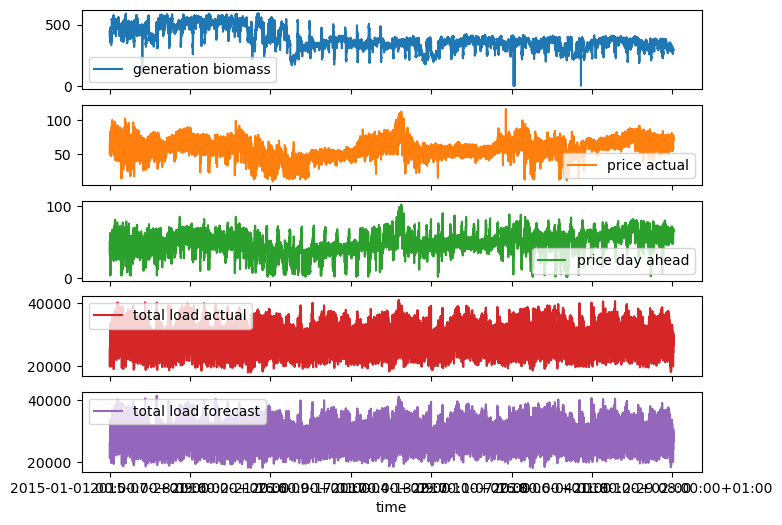

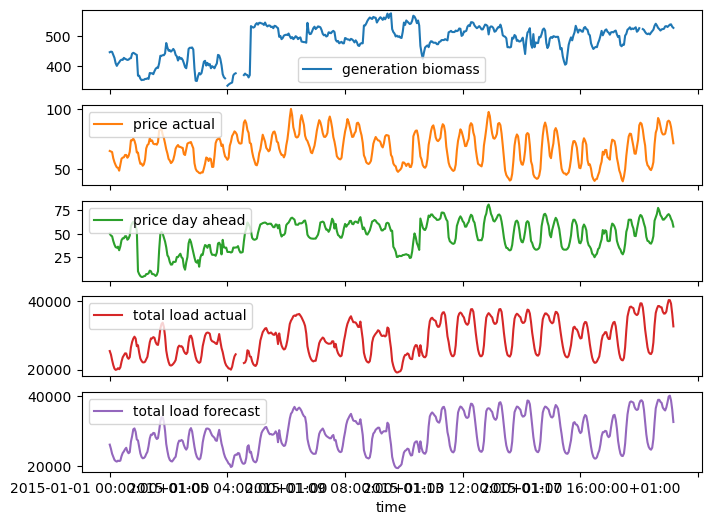

In [11]:
fig=plt.figure(figsize=(10,20))
date_time = df['time']
plot_cols = ['generation biomass', 'price actual', 'price day ahead', 'total load actual', 'total load forecast']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True);

## ✅ **Tâche 4a: Évaluer les modèles de baseline**

Nous utiliserons le dictionnaire suivant pour définir les configurations de la fonction `hyperparameter_sweep()` pour différents modèles et observer leurs performances.

In [25]:
sweep_cfg = {
    'model_name': 'baseline-mean',
    "target": 'price actual',
    "col_offset": 1,
    "hp_name": 'window_size',
    "hp_values": [8,16,32,64,128,256],
    "metric": 'RMSE',
    "epochs": 50,
    "lr": 1e-3,
    "batch_size": 128,
    "test_bs": 256,
}

[1 point]

### 📌 Q4.1 Modifiez le dictionnaire `sweep_cfg` pour obtenir les résultats du modèle de baseline de la moyenne.


In [13]:
## Student TODO ##
sweep_cfg['model_name'] = 'baseline-mean'
best_score, best_hp = hyperparameter_sweep(df, sweep_cfg)

(35064,) 8.355258e-08 1.0


100%|██████████| 198/198 [00:00<00:00, 19930.69it/s]

(35064,) 8.355258e-08 1.0


100%|██████████| 198/198 [00:00<00:00, 20300.48it/s]


(35064,) 8.355258e-08 1.0


100%|██████████| 197/197 [00:00<00:00, 19830.99it/s]


(35064,) 8.355258e-08 1.0


100%|██████████| 197/197 [00:00<00:00, 19759.85it/s]


(35064,) 8.355258e-08 1.0


100%|██████████| 197/197 [00:00<00:00, 19301.95it/s]


(35064,) 8.355258e-08 1.0


100%|██████████| 196/196 [00:00<00:00, 18417.09it/s]


(35064,) 8.355258e-08 1.0


100%|██████████| 194/194 [00:00<00:00, 16452.91it/s]

Best Mean Squared Error:  0.3565251
Best Window Size:  8


[1 point]

### 📌 Q4.2 Modifiez le dictionnaire `sweep_cfg` pour obtenir les résultats du modèle de baseline de la dernière valeur (last).


In [14]:
## Student TODO ##
sweep_cfg['model_name'] = 'baseline-last'
best_score, best_hp = hyperparameter_sweep(df, sweep_cfg)

(35064,) 8.355258e-08 1.0


  0%|          | 0/198 [00:00<?, ?it/s]

100%|██████████| 198/198 [00:00<00:00, 21843.04it/s]


(35064,) 8.355258e-08 1.0


100%|██████████| 198/198 [00:00<00:00, 22340.74it/s]


(35064,) 8.355258e-08 1.0


100%|██████████| 197/197 [00:00<00:00, 22479.47it/s]


(35064,) 8.355258e-08 1.0


100%|██████████| 197/197 [00:00<00:00, 13554.43it/s]


(35064,) 8.355258e-08 1.0


100%|██████████| 197/197 [00:00<00:00, 20510.30it/s]


(35064,) 8.355258e-08 1.0


100%|██████████| 196/196 [00:00<00:00, 13104.07it/s]


(35064,) 8.355258e-08 1.0


100%|██████████| 194/194 [00:00<00:00, 10758.61it/s]

Best Mean Squared Error:  0.06686295
Best Window Size:  512


## ✅ **Tâche 4b: Entrainer le modèle AR linéaire et régler la taille de la fenêtre**

[2 points]

### 📌 Q4.3 Modifiez le dictionnaire sweep_cfg pour obtenir les résultats du modèle AR linéaire et régler pour le window_size optimal.

In [26]:
## Student TODO ##
sweep_cfg['model_name'] = 'ar-linear'
best_score, best_hp = hyperparameter_sweep(df, sweep_cfg)

(35064,) 8.355258e-08 1.0
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_75 (Dense)            (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
115/198 [================>.............] - ETA: 0s - loss: 0.3727 - mae: 0.4687 - mse: 0.3727 

2023-12-11 14:40:19.887449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


198/198 [==============================] - 0s 764us/step - loss: 0.3361 - mae: 0.4435 - mse: 0.3361 - val_loss: 0.4297 - val_mae: 0.5215 - val_mse: 0.4297
Epoch 2/50
198/198 [==============================] - 0s 506us/step - loss: 0.2483 - mae: 0.3783 - mse: 0.2483 - val_loss: 0.3299 - val_mae: 0.4520 - val_mse: 0.3299
Epoch 3/50
  1/198 [..............................] - ETA: 1s - loss: 0.2653 - mae: 0.4201 - mse: 0.2653

2023-12-11 14:40:20.104991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


198/198 [==============================] - 0s 602us/step - loss: 0.1862 - mae: 0.3247 - mse: 0.1862 - val_loss: 0.2399 - val_mae: 0.3795 - val_mse: 0.2399
Epoch 4/50
198/198 [==============================] - 0s 526us/step - loss: 0.1412 - mae: 0.2793 - mse: 0.1412 - val_loss: 0.1868 - val_mae: 0.3289 - val_mse: 0.1868
Epoch 5/50
198/198 [==============================] - 0s 541us/step - loss: 0.1100 - mae: 0.2432 - mse: 0.1100 - val_loss: 0.1417 - val_mae: 0.2797 - val_mse: 0.1417
Epoch 6/50
198/198 [==============================] - 0s 531us/step - loss: 0.0895 - mae: 0.2175 - mse: 0.0895 - val_loss: 0.1172 - val_mae: 0.2493 - val_mse: 0.1172
Epoch 7/50
198/198 [==============================] - 0s 557us/step - loss: 0.0766 - mae: 0.1998 - mse: 0.0766 - val_loss: 0.1023 - val_mae: 0.2305 - val_mse: 0.1023
Epoch 8/50
198/198 [==============================] - 0s 531us/step - loss: 0.0690 - mae: 0.1889 - mse: 0.0690 - val_loss: 0.0915 - val_mae: 0.2178 - val_mse: 0.0915
Epoch 9/50
198/

2023-12-11 14:40:25.695619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-12-11 14:40:25.773591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


198/198 [==============================] - 0s 957us/step - loss: 5.3995 - mae: 1.7599 - mse: 5.3995 - val_loss: 3.6587 - val_mae: 1.5170 - val_mse: 3.6587
Epoch 2/50
117/198 [================>.............] - ETA: 0s - loss: 2.5470 - mae: 1.2276 - mse: 2.5470

2023-12-11 14:40:26.010238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


198/198 [==============================] - 0s 730us/step - loss: 2.3155 - mae: 1.1742 - mse: 2.3155 - val_loss: 2.5487 - val_mae: 1.3005 - val_mse: 2.5487
Epoch 3/50
198/198 [==============================] - 0s 635us/step - loss: 1.5039 - mae: 0.9483 - mse: 1.5039 - val_loss: 2.1766 - val_mae: 1.1982 - val_mse: 2.1766
Epoch 4/50
198/198 [==============================] - 0s 848us/step - loss: 1.2394 - mae: 0.8563 - mse: 1.2394 - val_loss: 1.8661 - val_mae: 1.1064 - val_mse: 1.8661
Epoch 5/50
198/198 [==============================] - 0s 784us/step - loss: 1.0522 - mae: 0.7876 - mse: 1.0522 - val_loss: 1.5803 - val_mae: 1.0164 - val_mse: 1.5803
Epoch 6/50
198/198 [==============================] - 0s 711us/step - loss: 0.8849 - mae: 0.7223 - mse: 0.8849 - val_loss: 1.3151 - val_mae: 0.9252 - val_mse: 1.3151
Epoch 7/50
198/198 [==============================] - 0s 977us/step - loss: 0.7378 - mae: 0.6575 - mse: 0.7378 - val_loss: 1.0841 - val_mae: 0.8366 - val_mse: 1.0841
Epoch 8/50
198/

2023-12-11 14:40:36.140147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-12-11 14:40:36.255018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


197/197 [==============================] - 0s 697us/step - loss: 0.3755 - mae: 0.4625 - mse: 0.3755 - val_loss: 0.2787 - val_mae: 0.4109 - val_mse: 0.2787
Epoch 2/50
197/197 [==============================] - 0s 554us/step - loss: 0.1414 - mae: 0.2828 - mse: 0.1414 - val_loss: 0.1519 - val_mae: 0.2985 - val_mse: 0.1519
Epoch 3/50
  1/197 [..............................] - ETA: 1s - loss: 0.0205 - mae: 0.1109 - mse: 0.0205

2023-12-11 14:40:36.458141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


197/197 [==============================] - 0s 598us/step - loss: 0.0980 - mae: 0.2357 - mse: 0.0980 - val_loss: 0.1218 - val_mae: 0.2646 - val_mse: 0.1218
Epoch 4/50
197/197 [==============================] - 0s 520us/step - loss: 0.0808 - mae: 0.2132 - mse: 0.0808 - val_loss: 0.1031 - val_mae: 0.2414 - val_mse: 0.1031
Epoch 5/50
197/197 [==============================] - 0s 532us/step - loss: 0.0691 - mae: 0.1964 - mse: 0.0691 - val_loss: 0.0901 - val_mae: 0.2240 - val_mse: 0.0901
Epoch 6/50
197/197 [==============================] - 0s 519us/step - loss: 0.0605 - mae: 0.1830 - mse: 0.0605 - val_loss: 0.0800 - val_mae: 0.2100 - val_mse: 0.0800
Epoch 7/50
197/197 [==============================] - 0s 528us/step - loss: 0.0545 - mae: 0.1728 - mse: 0.0545 - val_loss: 0.0736 - val_mae: 0.2002 - val_mse: 0.0736
Epoch 8/50
197/197 [==============================] - 0s 530us/step - loss: 0.0503 - mae: 0.1655 - mse: 0.0503 - val_loss: 0.0675 - val_mae: 0.1907 - val_mse: 0.0675
Epoch 9/50
197/

2023-12-11 14:40:42.024282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-12-11 14:40:42.108542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


197/197 [==============================] - 0s 721us/step - loss: 0.4696 - mae: 0.4976 - mse: 0.4696 - val_loss: 0.2953 - val_mae: 0.4046 - val_mse: 0.2953
Epoch 2/50
197/197 [==============================] - 0s 542us/step - loss: 0.1620 - mae: 0.2967 - mse: 0.1620 - val_loss: 0.1768 - val_mae: 0.3173 - val_mse: 0.1768
Epoch 3/50
  1/197 [..............................] - ETA: 1s - loss: 0.1586 - mae: 0.3201 - mse: 0.1586

2023-12-11 14:40:42.316908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


197/197 [==============================] - 0s 512us/step - loss: 0.1126 - mae: 0.2502 - mse: 0.1126 - val_loss: 0.1471 - val_mae: 0.2880 - val_mse: 0.1471
Epoch 4/50
197/197 [==============================] - 0s 530us/step - loss: 0.0963 - mae: 0.2316 - mse: 0.0963 - val_loss: 0.1320 - val_mae: 0.2722 - val_mse: 0.1320
Epoch 5/50
197/197 [==============================] - 0s 502us/step - loss: 0.0860 - mae: 0.2183 - mse: 0.0860 - val_loss: 0.1212 - val_mae: 0.2590 - val_mse: 0.1212
Epoch 6/50
197/197 [==============================] - 0s 493us/step - loss: 0.0783 - mae: 0.2079 - mse: 0.0783 - val_loss: 0.1118 - val_mae: 0.2487 - val_mse: 0.1118
Epoch 7/50
197/197 [==============================] - 0s 497us/step - loss: 0.0727 - mae: 0.1996 - mse: 0.0727 - val_loss: 0.1028 - val_mae: 0.2367 - val_mse: 0.1028
Epoch 8/50
197/197 [==============================] - 0s 469us/step - loss: 0.0687 - mae: 0.1939 - mse: 0.0687 - val_loss: 0.0965 - val_mae: 0.2287 - val_mse: 0.0965
Epoch 9/50
197/

2023-12-11 14:40:47.856201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-12-11 14:40:47.941225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


197/197 [==============================] - 0s 708us/step - loss: 0.6476 - mae: 0.5832 - mse: 0.6476 - val_loss: 0.4013 - val_mae: 0.4831 - val_mse: 0.4013
Epoch 2/50
197/197 [==============================] - 0s 506us/step - loss: 0.2147 - mae: 0.3525 - mse: 0.2147 - val_loss: 0.2781 - val_mae: 0.3997 - val_mse: 0.2781
Epoch 3/50
  1/197 [..............................] - ETA: 1s - loss: 0.2817 - mae: 0.4204 - mse: 0.2817

2023-12-11 14:40:48.142503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


197/197 [==============================] - 0s 537us/step - loss: 0.1579 - mae: 0.3031 - mse: 0.1579 - val_loss: 0.2167 - val_mae: 0.3527 - val_mse: 0.2167
Epoch 4/50
197/197 [==============================] - 0s 529us/step - loss: 0.1254 - mae: 0.2696 - mse: 0.1254 - val_loss: 0.1812 - val_mae: 0.3213 - val_mse: 0.1812
Epoch 5/50
197/197 [==============================] - 0s 550us/step - loss: 0.1056 - mae: 0.2470 - mse: 0.1056 - val_loss: 0.1591 - val_mae: 0.3007 - val_mse: 0.1591
Epoch 6/50
197/197 [==============================] - 0s 543us/step - loss: 0.0925 - mae: 0.2306 - mse: 0.0925 - val_loss: 0.1437 - val_mae: 0.2847 - val_mse: 0.1437
Epoch 7/50
197/197 [==============================] - 0s 514us/step - loss: 0.0831 - mae: 0.2180 - mse: 0.0831 - val_loss: 0.1303 - val_mae: 0.2708 - val_mse: 0.1303
Epoch 8/50
197/197 [==============================] - 0s 514us/step - loss: 0.0761 - mae: 0.2081 - mse: 0.0761 - val_loss: 0.1209 - val_mae: 0.2591 - val_mse: 0.1209
Epoch 9/50
197/

2023-12-11 14:40:53.759401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-12-11 14:40:53.857943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


160/196 [=======================>......] - ETA: 0s - loss: 0.5115 - mae: 0.5251 - mse: 0.5115

2023-12-11 14:40:54.379911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


196/196 [==============================] - 1s 3ms/step - loss: 0.4661 - mae: 0.5009 - mse: 0.4661 - val_loss: 0.3400 - val_mae: 0.4409 - val_mse: 0.3400
Epoch 2/50
196/196 [==============================] - 0s 2ms/step - loss: 0.2100 - mae: 0.3454 - mse: 0.2100 - val_loss: 0.2291 - val_mae: 0.3653 - val_mse: 0.2291
Epoch 3/50
196/196 [==============================] - 0s 1ms/step - loss: 0.1269 - mae: 0.2724 - mse: 0.1269 - val_loss: 0.1811 - val_mae: 0.3230 - val_mse: 0.1811
Epoch 4/50
196/196 [==============================] - 0s 1ms/step - loss: 0.1006 - mae: 0.2427 - mse: 0.1006 - val_loss: 0.1473 - val_mae: 0.2918 - val_mse: 0.1473
Epoch 5/50
196/196 [==============================] - 0s 2ms/step - loss: 0.0847 - mae: 0.2229 - mse: 0.0847 - val_loss: 0.1258 - val_mae: 0.2697 - val_mse: 0.1258
Epoch 6/50
196/196 [==============================] - 1s 3ms/step - loss: 0.0801 - mae: 0.2158 - mse: 0.0801 - val_loss: 0.1117 - val_mae: 0.2537 - val_mse: 0.1117
Epoch 7/50
196/196 [=======

2023-12-11 14:41:18.599348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


## ✅ **Tâche 4c: Entrainer le modèle AR MLP et ajuster la taille de la fenêtre**

[2 points]

### 📌 Q4.4 Modifiez le dictionnaire sweep_cfg pour obtenir les résultats du modèle AR MP et régler pour le window_size optimal.

In [ ]:
# ## Student TODO ##
dims = [1, 2, 4, 8, 16, 32, 64, 128]


best_hp = None
best_score = float('inf')
best_dim = None

for dim in dims:
    sweep_cfg['model_name'] = 'ar-mlp'
    sweep_cfg['mlp_dim'] = dim
    score, hp = hyperparameter_sweep(df, sweep_cfg)
    if score < best_score:
        best_score = score
        best_hp = hp
        best_dim = dim
print("Best MLP dimension: ", best_dim)
print("Best MLP Mean Squared Error: ", best_score)
print("Best MLP Window Size: ", best_hp)


J'ai roulé la cellule dessus (j'ai remove le ouput car c'est long) et j'ai trouvé:
```
Best MLP dimension:  4
Best MLP Mean Squared Error:  0.04491307958960533
Best MLP Window Size:  32 
```

<!-- Best MLP dimension:  4
Best MLP Mean Squared Error:  0.04491307958960533
Best MLP Window Size:  32 -->

## ✅ **Tâche 4d: Visualiser les prédictions**

[3 points]

### 📌 Q4.5 Générez un graphique pour comparer visuellement les séries temporelles de l'ensemble de test prédites par le meilleur modèle et les séries temporelles réelles.

In [27]:
# best model:
sweep_cfg['model_name'] = 'ar-mlp'
sweep_cfg['window_size'] = 32
sweep_cfg['mlp_dim'] = 4
best_model = create_model(sweep_cfg)

data = preprocess_dataset(df, sweep_cfg['target'], lookback=sweep_cfg['window_size'])
train_generator, val_generator, test_generator = prepare_dataloaders(data, sweep_cfg)

best_model.compile(loss='mse', optimizer=Adam(learning_rate=sweep_cfg['lr']), metrics=['mae', 'mse']);
best_model.fit(train_generator, epochs=sweep_cfg['epochs'], validation_data=val_generator, batch_size=sweep_cfg['batch_size']);

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_81 (Dense)            (None, 4)                 132       
                                                                 
 dense_82 (Dense)            (None, 1)                 5         
                                                                 
Total params: 137
Trainable params: 137
Non-trainable params: 0
_________________________________________________________________
None
(35064,) 8.355258e-08 1.0
Epoch 1/50
  1/197 [..............................] - ETA: 26s - loss: 1.3952 - mae: 0.9506 - mse: 1.3952

2023-12-11 14:41:18.861407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


197/197 [==============================] - 1s 3ms/step - loss: 1.3683 - mae: 0.8664 - mse: 1.3683 - val_loss: 0.7897 - val_mae: 0.6617 - val_mse: 0.7897


2023-12-11 14:41:19.338933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 2/50
197/197 [==============================] - 0s 2ms/step - loss: 0.6992 - mae: 0.6191 - mse: 0.6992 - val_loss: 0.5576 - val_mae: 0.5305 - val_mse: 0.5576
Epoch 3/50
197/197 [==============================] - 0s 2ms/step - loss: 0.5760 - mae: 0.5407 - mse: 0.5760 - val_loss: 0.4662 - val_mae: 0.4631 - val_mse: 0.4662
Epoch 4/50
197/197 [==============================] - 0s 2ms/step - loss: 0.5037 - mae: 0.4915 - mse: 0.5037 - val_loss: 0.4144 - val_mae: 0.4229 - val_mse: 0.4144
Epoch 5/50
197/197 [==============================] - 1s 3ms/step - loss: 0.4511 - mae: 0.4578 - mse: 0.4511 - val_loss: 0.3812 - val_mae: 0.4002 - val_mse: 0.3812
Epoch 6/50
197/197 [==============================] - 0s 1ms/step - loss: 0.4116 - mae: 0.4341 - mse: 0.4116 - val_loss: 0.3597 - val_mae: 0.3873 - val_mse: 0.3597
Epoch 7/50
197/197 [==============================] - 0s 1ms/step - loss: 0.3780 - mae: 0.4116 - mse: 0.3780 - val_loss: 0.3345 - val_mae: 0.3688 - val_mse: 0.3345
Epoch 8/50
197/1

 1/55 [..............................] - ETA: 1s

55/55 [==============================] - 0s 3ms/step


2023-12-11 14:41:41.603711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


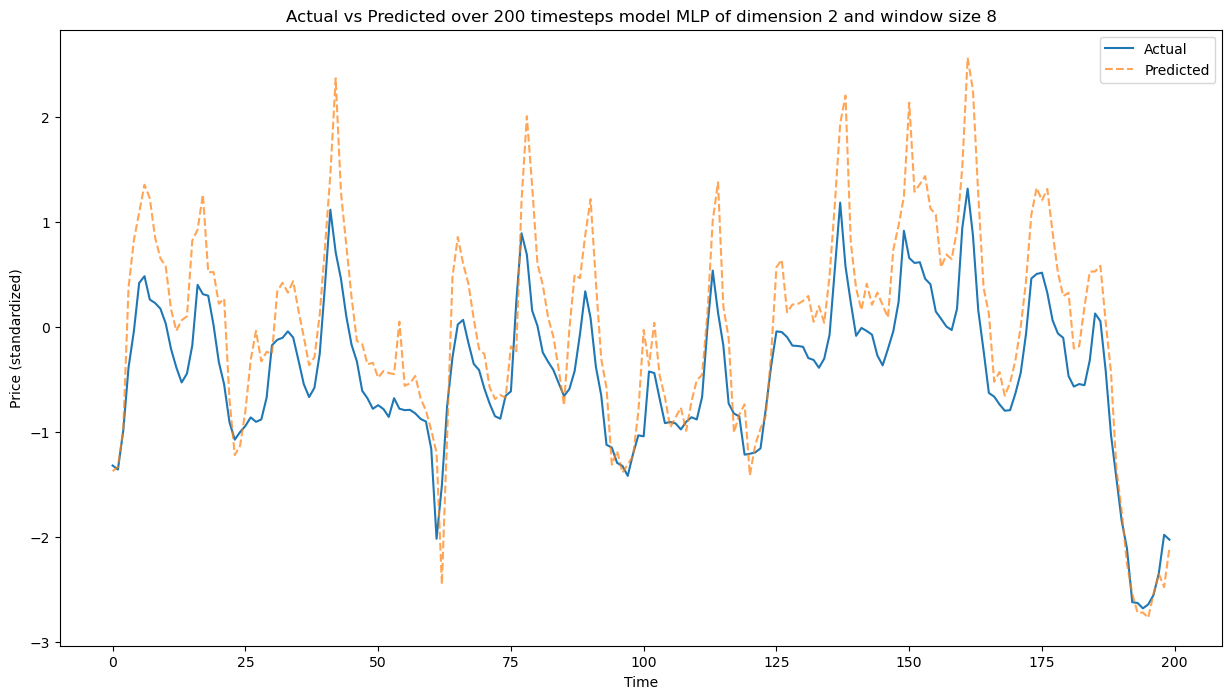

In [28]:
# Student TODO START

test_predict = best_model.predict(test_generator, batch_size=sweep_cfg['test_bs'])
test_predict = test_predict.flatten()[:200]
trimmed_targets = test_generator.targets[sweep_cfg['window_size']:][:200] # because model predicts the next `window_size` points

test_predict = standardize_features(test_predict)

test_index = np.arange(len(trimmed_targets))

plt.figure(figsize=(15,8))
plt.plot(test_index, trimmed_targets, label='Actual')
plt.plot(test_index, test_predict, label='Predicted', alpha=0.7, linestyle='--')
plt.title('Actual vs Predicted over 200 timesteps model MLP of dimension 2 and window size 8')
plt.xlabel('Time')
plt.ylabel('Price (standardized)')
plt.legend()
plt.show()

# Student TODO END

[3 points]

### 📌 Q4.6 : Quel modèle fonctionne le mieux? Lequel est le pire? Donnez une explication de vos propres mots sur pourquoi vous observez cela.


Notre meilleur modèle est un MLP avec 4 couche cachées sur une fenêtre de 32. Le pire model est le 'baseline-last'.
Cela peut-être expliqué par le fait que le MLP a une capacité significative à apprendre les relations non linéaires dans les données. Cette complexité lui permet de faire des prévisions plus précises en considérant une plus large gamme d'informations passées. Un MLP peut aussi parfois être plus robustes face au bruit et aux anomalies dans les données.
L'approce naïve du dernier élement ignore toutes les tendances, la saisonnalité ou les motifs présents dans les données. Dans notre contexte des prix de l'énergie, où les valeurs passées et les tendances sont importantes, cette approche est trop simple. Elle ne va pas s'adapter aux données, échouant à capturer des motifs essentiels de nos données.

# Jeu de données 2 : Cours boursiers

Ce jeu de données se compose d'attributs variés liés aux cours boursiers de diverses sociétés cotées en bourse.

## Charger les données et les visualiser


In [10]:
dataset = load_dataset("edarchimbaud/timeseries-1m-stocks")
df = dataset['train'].to_pandas()
df

,symbol,datetime,open,high,low,close,volume
0,A,2023-05-26 15:30:00,120.070000,120.195000,119.830002,120.195000,23427.0
1,A,2023-05-26 15:31:00,120.349998,120.720001,120.190002,120.720001,2715.0
2,A,2023-05-26 15:32:00,120.480003,120.480003,120.084999,120.084999,2683.0
3,A,2023-05-26 15:33:00,120.199997,120.449997,120.160004,120.180000,3832.0
4,A,2023-05-26 15:34:00,120.239998,120.309998,120.239998,120.309998,359.0
...,...,...,...,...,...,...,...
3283789,ZTS,2023-11-20 20:56:00,175.910004,176.029999,175.910004,176.020004,9226.0
3283790,ZTS,2023-11-20 20:57:00,176.029999,176.130005,176.000000,176.039993,18115.0
3283791,ZTS,2023-11-20 20:58:00,176.070007,176.179993,176.070007,176.160004,13280.0
3283792,ZTS,2023-11-20 20:59:00,176.145004,176.190002,176.000000,176.080002,48042.0


Concentrons-nous sur les cours boursiers d'Apple Inc., représentés par le code 'AAPL'.

In [11]:
df.index = df['symbol']
del df['symbol']
df.xs('AAPL')

,datetime,open,high,low,close,volume
symbol,,,,,,
AAPL,2023-05-26 15:30:00,173.320007,173.600006,173.110001,173.320007,1249137.0
AAPL,2023-05-26 15:31:00,173.320007,173.740005,173.270004,173.639999,258116.0
AAPL,2023-05-26 15:32:00,173.619995,173.719894,173.470001,173.660004,195140.0
AAPL,2023-05-26 15:33:00,173.660004,173.830002,173.610001,173.829193,258145.0
AAPL,2023-05-26 15:34:00,173.824997,173.869995,173.498993,173.500000,155033.0
...,...,...,...,...,...,...
AAPL,2023-11-20 20:56:00,191.279999,191.354996,191.240005,191.309998,221349.0
AAPL,2023-11-20 20:57:00,191.309998,191.419998,191.300003,191.365005,269412.0
AAPL,2023-11-20 20:58:00,191.369995,191.380005,191.330002,191.350006,307116.0


Visualisons certaines caractéristiques.



<Figure size 1000x2000 with 0 Axes>

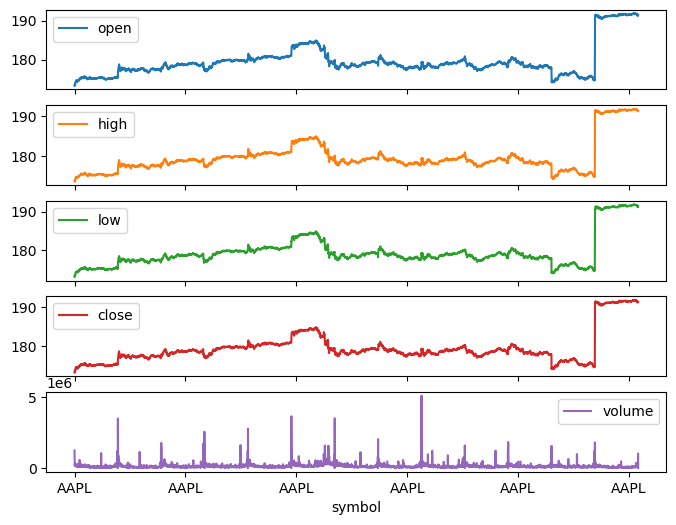

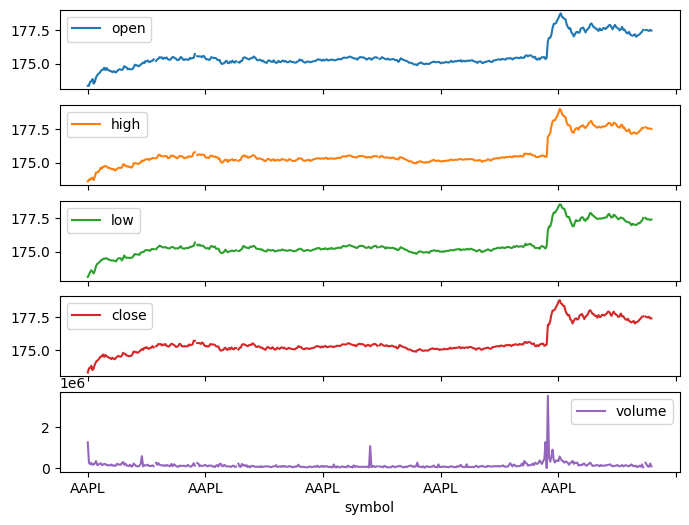

In [12]:
fig=plt.figure(figsize=(10,20))
date_time = df.xs('AAPL')['datetime']
plot_cols = ['open', 'high', 'low', 'close', 'volume'] # Use actual features
plot_features = df.xs('AAPL')[plot_cols]
# plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df.xs('AAPL')[plot_cols][:480]
# plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True);

## ✅ **Tâche 5a: Évaluer les modèles de baseline**

Nous utiliserons le dictionnaire suivant pour définir les configurations de la fonction `hyperparameter_sweep()` pour différents modèles et observer leurs performances.

In [29]:
sweep_cfg = {
    'model_name': 'baseline-mean',
    "target": 'high',
    "col_offset": 1,
    "hp_name": 'window_size',
    "hp_values": [8,16,32,64],
    "metric": 'RMSE',
    "epochs": 50,
    "lr": 1e-3,
    "batch_size": 128,
    "test_bs": 256,
}

#Utiliser uniquement les prix des actions d'Apple Inc. pour les tâches restantes.
df = df.xs('AAPL')

[1 point]

### 📌 Q5.1 Modifiez le dictionnaire `sweep_cfg` pour obtenir les résultats du modèle de baseline de la moyenne.


In [30]:
## Student TODO ##
sweep_cfg['model_name'] = 'baseline-mean'
best_score, best_hp = hyperparameter_sweep(df, sweep_cfg)

(5083,) 2.2814636e-07 1.0


100%|██████████| 4/4 [00:00<00:00, 3217.72it/s]


(5083,) 2.2814636e-07 1.0


100%|██████████| 4/4 [00:00<00:00, 2464.70it/s]


(5083,) 2.2814636e-07 1.0


100%|██████████| 3/3 [00:00<00:00, 2908.67it/s]


(5083,) 2.2814636e-07 1.0


100%|██████████| 3/3 [00:00<00:00, 2970.47it/s]

Best Mean Squared Error:  0.9843594751891942
Best Window Size:  16


[1 point]

### 📌 Q5.2 Modifiez le dictionnaire `sweep_cfg` pour obtenir les résultats du modèle de baseline de la dernière valeur (last).


In [34]:
## Student TODO ##
sweep_cfg['model_name'] = 'baseline-last'
best_score, best_hp = hyperparameter_sweep(df, sweep_cfg)

(5083,) 2.2814636e-07 1.0


100%|██████████| 29/29 [00:00<00:00, 15486.99it/s]


(5083,) 2.2814636e-07 1.0


100%|██████████| 29/29 [00:00<00:00, 16432.70it/s]


(5083,) 2.2814636e-07 1.0


100%|██████████| 29/29 [00:00<00:00, 16353.16it/s]


(5083,) 2.2814636e-07 1.0


100%|██████████| 29/29 [00:00<00:00, 14638.92it/s]


(5083,) 2.2814636e-07 1.0


100%|██████████| 28/28 [00:00<00:00, 14798.45it/s]

Best Mean Squared Error:  1.6598874
Best Window Size:  128


## ✅ **Tâche 5b: Entrainer le modèle AR linéaire et régler la taille de la fenêtre**

[2 points]

### 📌 Q5.3 Modifiez le dictionnaire sweep_cfg pour obtenir les résultats du modèle AR linéaire et régler pour le window_size optimal.

In [35]:
## Student TODO ##
sweep_cfg['model_name'] = 'ar-linear'
best_score, best_hp = hyperparameter_sweep(df, sweep_cfg)

(5083,) 2.2814636e-07 1.0
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_83 (Dense)            (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
 1/29 [>.............................] - ETA: 3s - loss: 3.4307 - mae: 0.4744 - mse: 3.4307

2023-12-11 14:41:45.785347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-12-11 14:41:45.947180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


29/29 [==============================] - 0s 3ms/step - loss: 2.0412 - mae: 0.4068 - mse: 2.0412 - val_loss: 2.1023 - val_mae: 0.3188 - val_mse: 2.1023
Epoch 2/50
29/29 [==============================] - 0s 2ms/step - loss: 1.9717 - mae: 0.3929 - mse: 1.9717 - val_loss: 2.0344 - val_mae: 0.3102 - val_mse: 2.0344
Epoch 3/50
29/29 [==============================] - 0s 2ms/step - loss: 1.9061 - mae: 0.3812 - mse: 1.9061 - val_loss: 1.9764 - val_mae: 0.3025 - val_mse: 1.9764
Epoch 4/50
29/29 [==============================] - 0s 2ms/step - loss: 1.8465 - mae: 0.3702 - mse: 1.8465 - val_loss: 1.9243 - val_mae: 0.2958 - val_mse: 1.9243
Epoch 5/50
29/29 [==============================] - 0s 3ms/step - loss: 1.7919 - mae: 0.3596 - mse: 1.7919 - val_loss: 1.8719 - val_mae: 0.2893 - val_mse: 1.8719
Epoch 6/50
29/29 [==============================] - 0s 2ms/step - loss: 1.7384 - mae: 0.3493 - mse: 1.7384 - val_loss: 1.8269 - val_mae: 0.2830 - val_mse: 1.8269
Epoch 7/50
29/29 [=====================

2023-12-11 14:41:50.901332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-12-11 14:41:51.023766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


29/29 [==============================] - 0s 3ms/step - loss: 3.3414 - mae: 0.5122 - mse: 3.3414 - val_loss: 3.9782 - val_mae: 0.5495 - val_mse: 3.9782
Epoch 2/50
29/29 [==============================] - 0s 1ms/step - loss: 3.1888 - mae: 0.4950 - mse: 3.1888 - val_loss: 3.7854 - val_mae: 0.5315 - val_mse: 3.7854
Epoch 3/50
29/29 [==============================] - 0s 2ms/step - loss: 3.0458 - mae: 0.4782 - mse: 3.0458 - val_loss: 3.6070 - val_mae: 0.5145 - val_mse: 3.6070
Epoch 4/50


2023-12-11 14:41:51.211935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


29/29 [==============================] - 0s 2ms/step - loss: 2.9081 - mae: 0.4631 - mse: 2.9081 - val_loss: 3.4504 - val_mae: 0.5002 - val_mse: 3.4504
Epoch 5/50
29/29 [==============================] - 0s 2ms/step - loss: 2.7964 - mae: 0.4502 - mse: 2.7964 - val_loss: 3.2785 - val_mae: 0.4858 - val_mse: 3.2785
Epoch 6/50
29/29 [==============================] - 0s 2ms/step - loss: 2.6634 - mae: 0.4350 - mse: 2.6634 - val_loss: 3.1553 - val_mae: 0.4738 - val_mse: 3.1553
Epoch 7/50
29/29 [==============================] - 0s 2ms/step - loss: 2.5628 - mae: 0.4236 - mse: 2.5628 - val_loss: 3.0075 - val_mae: 0.4603 - val_mse: 3.0075
Epoch 8/50
29/29 [==============================] - 0s 2ms/step - loss: 2.4504 - mae: 0.4119 - mse: 2.4504 - val_loss: 2.8917 - val_mae: 0.4495 - val_mse: 2.8917
Epoch 9/50
29/29 [==============================] - 0s 2ms/step - loss: 2.3517 - mae: 0.4007 - mse: 2.3517 - val_loss: 2.7890 - val_mae: 0.4381 - val_mse: 2.7890
Epoch 10/50
29/29 [====================

2023-12-11 14:41:55.914109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-12-11 14:41:56.006508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


29/29 [==============================] - 0s 2ms/step - loss: 3.3377 - mae: 0.5358 - mse: 3.3377 - val_loss: 3.4939 - val_mae: 0.6131 - val_mse: 3.4939
Epoch 2/50
29/29 [==============================] - 0s 1ms/step - loss: 3.1413 - mae: 0.5115 - mse: 3.1413 - val_loss: 3.2542 - val_mae: 0.5845 - val_mse: 3.2542
Epoch 3/50
29/29 [==============================] - 0s 1ms/step - loss: 2.9515 - mae: 0.4911 - mse: 2.9515 - val_loss: 3.0761 - val_mae: 0.5626 - val_mse: 3.0761
Epoch 4/50
29/29 [==============================] - 0s 1ms/step - loss: 2.7935 - mae: 0.4721 - mse: 2.7935 - val_loss: 2.8712 - val_mae: 0.5354 - val_mse: 2.8712
Epoch 5/50
29/29 [==============================] - 0s 978us/step - loss: 2.6372 - mae: 0.4530 - mse: 2.6372 - val_loss: 2.7064 - val_mae: 0.5128 - val_mse: 2.7064


2023-12-11 14:41:56.223657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 6/50
29/29 [==============================] - 0s 1ms/step - loss: 2.5018 - mae: 0.4357 - mse: 2.5018 - val_loss: 2.5513 - val_mae: 0.4907 - val_mse: 2.5513
Epoch 7/50
29/29 [==============================] - 0s 1ms/step - loss: 2.3684 - mae: 0.4198 - mse: 2.3684 - val_loss: 2.4109 - val_mae: 0.4699 - val_mse: 2.4109
Epoch 8/50
29/29 [==============================] - 0s 988us/step - loss: 2.2520 - mae: 0.4035 - mse: 2.2520 - val_loss: 2.2851 - val_mae: 0.4503 - val_mse: 2.2851
Epoch 9/50
29/29 [==============================] - 0s 994us/step - loss: 2.1408 - mae: 0.3899 - mse: 2.1408 - val_loss: 2.1798 - val_mae: 0.4335 - val_mse: 2.1798
Epoch 10/50
29/29 [==============================] - 0s 960us/step - loss: 2.0483 - mae: 0.3768 - mse: 2.0483 - val_loss: 2.0625 - val_mae: 0.4145 - val_mse: 2.0625
Epoch 11/50
29/29 [==============================] - 0s 1ms/step - loss: 1.9521 - mae: 0.3635 - mse: 1.9521 - val_loss: 1.9682 - val_mae: 0.3981 - val_mse: 1.9682
Epoch 12/50
29/29 [=

2023-12-11 14:41:58.283411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-12-11 14:41:58.324844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-12-11 14:41:58.478234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


29/29 [==============================] - 0s 4ms/step - loss: 2.7594 - mae: 0.5862 - mse: 2.7594 - val_loss: 4.0872 - val_mae: 0.6791 - val_mse: 4.0872
Epoch 2/50
29/29 [==============================] - 0s 2ms/step - loss: 2.5291 - mae: 0.5497 - mse: 2.5291 - val_loss: 3.8105 - val_mae: 0.6453 - val_mse: 3.8105
Epoch 3/50
29/29 [==============================] - 0s 2ms/step - loss: 2.3362 - mae: 0.5227 - mse: 2.3362 - val_loss: 3.5226 - val_mae: 0.6094 - val_mse: 3.5226
Epoch 4/50
29/29 [==============================] - 0s 2ms/step - loss: 2.1571 - mae: 0.4962 - mse: 2.1571 - val_loss: 3.2856 - val_mae: 0.5790 - val_mse: 3.2856
Epoch 5/50
29/29 [==============================] - 0s 2ms/step - loss: 2.0122 - mae: 0.4691 - mse: 2.0122 - val_loss: 3.0572 - val_mae: 0.5494 - val_mse: 3.0572
Epoch 6/50
29/29 [==============================] - 0s 3ms/step - loss: 1.8771 - mae: 0.4481 - mse: 1.8771 - val_loss: 2.8446 - val_mae: 0.5212 - val_mse: 2.8446
Epoch 7/50
29/29 [=====================

2023-12-11 14:42:03.430838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-12-11 14:42:03.510924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


28/28 [==============================] - 0s 2ms/step - loss: 2.9169 - mae: 0.8142 - mse: 2.9169 - val_loss: 2.7164 - val_mae: 0.5689 - val_mse: 2.7164
Epoch 2/50
28/28 [==============================] - 0s 955us/step - loss: 2.5984 - mae: 0.7208 - mse: 2.5984 - val_loss: 2.5744 - val_mae: 0.5379 - val_mse: 2.5744
Epoch 3/50
28/28 [==============================] - 0s 1ms/step - loss: 2.3236 - mae: 0.6558 - mse: 2.3236 - val_loss: 2.4400 - val_mae: 0.5092 - val_mse: 2.4400
Epoch 4/50
28/28 [==============================] - 0s 1ms/step - loss: 2.0971 - mae: 0.6042 - mse: 2.0971 - val_loss: 2.3292 - val_mae: 0.4824 - val_mse: 2.3292
Epoch 5/50
28/28 [==============================] - 0s 1ms/step - loss: 1.9057 - mae: 0.5581 - mse: 1.9057 - val_loss: 2.2324 - val_mae: 0.4578 - val_mse: 2.2324


2023-12-11 14:42:03.663748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 6/50
28/28 [==============================] - 0s 1ms/step - loss: 1.7353 - mae: 0.5158 - mse: 1.7353 - val_loss: 2.1565 - val_mae: 0.4356 - val_mse: 2.1565
Epoch 7/50
28/28 [==============================] - 0s 968us/step - loss: 1.6096 - mae: 0.4833 - mse: 1.6096 - val_loss: 2.0765 - val_mae: 0.4100 - val_mse: 2.0765
Epoch 8/50
28/28 [==============================] - 0s 1ms/step - loss: 1.4731 - mae: 0.4431 - mse: 1.4731 - val_loss: 2.0226 - val_mae: 0.3927 - val_mse: 2.0226
Epoch 9/50
28/28 [==============================] - 0s 1ms/step - loss: 1.3786 - mae: 0.4109 - mse: 1.3786 - val_loss: 1.9754 - val_mae: 0.3750 - val_mse: 1.9754
Epoch 10/50
28/28 [==============================] - 0s 1ms/step - loss: 1.2945 - mae: 0.3818 - mse: 1.2945 - val_loss: 1.9346 - val_mae: 0.3580 - val_mse: 1.9346
Epoch 11/50
28/28 [==============================] - 0s 1ms/step - loss: 1.2194 - mae: 0.3526 - mse: 1.2194 - val_loss: 1.9036 - val_mae: 0.3432 - val_mse: 1.9036
Epoch 12/50
28/28 [=====

2023-12-11 14:42:05.579007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


## ✅ **Tâche 5c: Entrainer le modèle AR MLP et ajuster la taille de la fenêtre**

[2 points]

### 📌 Q5.4 Modifiez le dictionnaire sweep_cfg pour obtenir les résultats du modèle AR MP et régler pour le window_size optimal.

In [ ]:
## Student TODO ##
dims = [2, 4, 8, 16, 32, 64, 128, 256] # no point going more really

best_hp = None
best_score = float('inf')
best_dim = None

for dim in dims:
    sweep_cfg['model_name'] = 'ar-mlp'
    sweep_cfg['mlp_dim'] = dim
    score, hp = hyperparameter_sweep(df, sweep_cfg)
    if score < best_score:
        best_score = score
        best_hp = hp
        best_dim = dim
print("Best MLP dimension: ", best_dim)
print("Best MLP score: ", best_score)
print("Best MLP window: ", best_hp)

J'ai roulé la cellule dessus (enlever le ouput car c'est long) et j'ai trouvé:
```
Best Mean Squared Error:  1.2030177116394043
Best Window Size:  8
Best MLP dimension:  4
```

## ✅ **Tâche 5d: Visualiser les prédictions**

[3 points]

### 📌 Q5.5 Générez un graphique pour comparer visuellement les séries temporelles de l'ensemble de test prédites par le meilleur modèle et les séries temporelles réelles.

In [31]:
# best model:
sweep_cfg['model_name'] = 'baseline-mean'
sweep_cfg['window_size'] = 16
best_model = create_model(sweep_cfg)

data = preprocess_dataset(df, sweep_cfg['target'], lookback=sweep_cfg['window_size'])
_, _, test_generator = prepare_dataloaders(data, sweep_cfg)

(5083,) 2.2814636e-07 1.0


100%|██████████| 8/8 [00:00<00:00, 5721.13it/s]


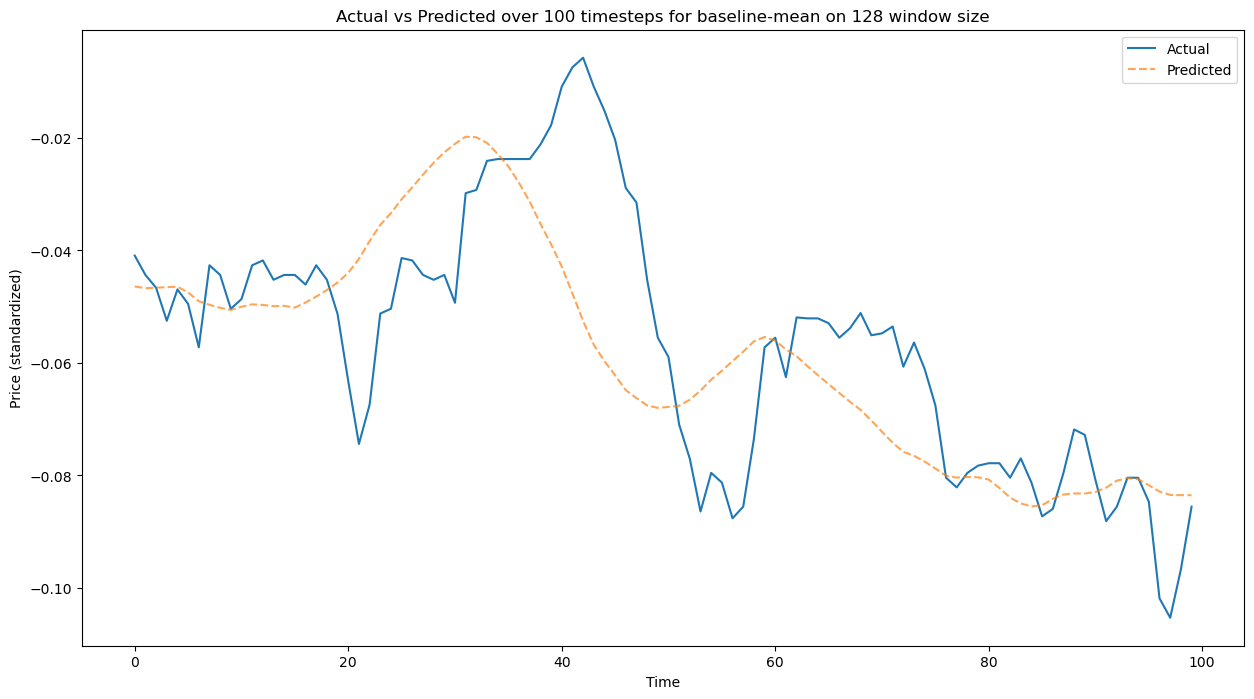

In [41]:
# Student TODO START
trimmed_targets = test_generator.targets[:100]

preds = []
for x, y in tqdm(test_generator):
    preds.append(best_model.predict(x))
                
preds = np.concatenate(preds)[:100]

test_index = np.arange(len(trimmed_targets))

plt.figure(figsize=(15,8))
plt.plot(test_index, trimmed_targets, label='Actual')
plt.plot(test_index, preds, label='Predicted', alpha=0.7, linestyle='--')
plt.title('Actual vs Predicted over 100 timesteps for baseline-mean on 128 window size')
plt.xlabel('Time')
plt.ylabel('Price (standardized)')
plt.legend()
plt.show()

# Student TODO END

[3 points]

### 📌 Q5.6 : Quel modèle fonctionne le mieux? Lequel est le pire? Donnez une explication de vos propres mots sur pourquoi vous observez cela.


Notre meilleur modèle est la moyenne des données sur une fenêtre de 16. Le pire model est le 'baseline-last' encore une fois.
Des données boursières, comme les prix des actions de Apple que nous avons, vont être très volatiles et sujet à des fluctuations rapides dues à divers facteurs externes.
La moyenne sur une fenêtre de 16 peut aider à lisser la volatilité à court terme et à refléter une tendance plus stable des prix des actions.
Encore une fois, le modèle du dernier élément est extrêmement simple et ne prend pas en compte les tendances ou la volatilité globale. Il va supposer que le marché est stable et continuera dans la direction du dernier prix observé, ce qui est presque jamais le cas.